In [18]:
#import aug_standart_ztf
import fulu
from sklearn.gaussian_process.kernels import RBF, Matern, \
RationalQuadratic, WhiteKernel, DotProduct, ConstantKernel as C
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from importlib import reload
reload(fulu)
import fulu
from fulu import bnn_aug
from fulu import nf_aug
from fulu import single_layer_aug
from fulu import mlp_reg_aug
from fulu import gp_aug
from fulu import *
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')


path = os.getcwd()
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

N_OBS = 1000

models_dict = {'BNN': bnn_aug.BayesianNetAugmentation(passband2lam),
               'NF': nf_aug.NormalizingFlowAugmentation(passband2lam),
               'NN (pytorch)': single_layer_aug.SingleLayerNetAugmentation(passband2lam),
               'NN (sklearn)': mlp_reg_aug.MLPRegressionAugmentation(passband2lam),
               'GP': gp_aug.GaussianProcessesAugmentation(passband2lam),
               'GP C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*RBF([1.0, 1.0]) + Matern() + WhiteKernel(),  False),\
               'GP C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel()': gp_aug.GaussianProcessesAugmentation(passband2lam, C(1.0)*Matern() * RBF([1, 1]) + Matern() + WhiteKernel())}


anobject = pd.read_csv(path + '/object_34299.csv', sep = ',')

def test(model_name):
    model = models_dict[model_name]
    
    anobject_train, anobject_test = train_test_split(anobject, test_size = 0.5, random_state=11)

    model.fit(anobject_train['mjd'].values, anobject_train['flux'].values, 
          anobject_train['flux_err'].values, anobject_train['passband'].values)


    # augmentation
    t_aug, flux_aug, flux_err_aug, passbands_aug = model.augmentation(anobject['mjd'].min(), 
                                                                  anobject['mjd'].max(), 
                                                                  n_obs=N_OBS)


    model.plot()
    model.plot(plot_approx = False)
    model.plot(passband=1)
    model.plot(passband=0)
    model.plot(true_peak=59000)
    model.plot(plot_peak=True)
    model.plot(title="Amazing graph")
    model.plot(true_peak=59000, plot_peak=True,
                         title="Amazing graph", save=model_name + "_.pdf")
    plotic = LcPlotter(passband2lam)
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=1, title="train observation and approx curves")

    ax = plotic.plot_sum_passbands(t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)

    plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                         flux=anobject_train['flux'].values,
                         flux_err=anobject_train['flux_err'].values,
                         passbands=anobject_train['passband'].values, 
                              plot_peak=True)
    plotic.plot_one_graph_all(t=anobject_train['mjd'].values,
                         flux=anobject_train['flux'].values,
                         flux_err=anobject_train['flux_err'].values,
                         passbands=anobject_train['passband'].values, 
                              plot_peak=True,
                              t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=1, label='train')
    ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                            flux=anobject_test['flux'].values,
                            flux_err=anobject_test['flux_err'].values,
                            passbands=anobject_test['passband'].values,
                                passband = 1,
                                ax=ax,
                                label = 'test',
                                marker = 'o')
    ax = plotic.errorbar_passband(t=anobject_train['mjd'].values, 
                             flux=anobject_train['flux'].values, 
                             flux_err=anobject_train['flux_err'].values, 
                             passbands=anobject_train['passband'].values, 
                             passband=0, ax=ax, label = 'train')

    ax = plotic.errorbar_passband(t=anobject_test['mjd'].values,
                            flux=anobject_test['flux'].values,
                            flux_err=anobject_test['flux_err'].values,
                            passbands=anobject_test['passband'].values,
                                  passband=0,
                                  ax=ax,
                                  marker = 'o',
                                  label='test')

    ax = plotic.plot_approx(t_approx=t_aug, 
                       flux_approx=flux_aug,
                       flux_err_approx=flux_err_aug,
                       passband_approx=passbands_aug,
                       passband=1)
    plotic.plot_approx(t_approx=t_aug, 
                       flux_approx=flux_aug,
                       flux_err_approx=flux_err_aug,
                       passband_approx=passbands_aug,
                       passband=0, ax=ax)

    plotic.plot_one_graph_passband(t=anobject_train['mjd'].values, 
                                   flux=anobject_train['flux'].values, 
                                   flux_err=anobject_train['flux_err'].values,
                                   passbands=anobject_train['passband'].values, 
                                   passband=0, title="Wow", t_approx=t_aug, 
                              flux_approx=flux_aug,
                              flux_err_approx=flux_err_aug, 
                              passband_approx=passbands_aug)

    ax = plotic.plot_true_peak(true_peak = 59000, title="Title1")
    plotic.plot_true_peak(true_peak=59200, title="Title2", ax=ax)

Your graph was saved


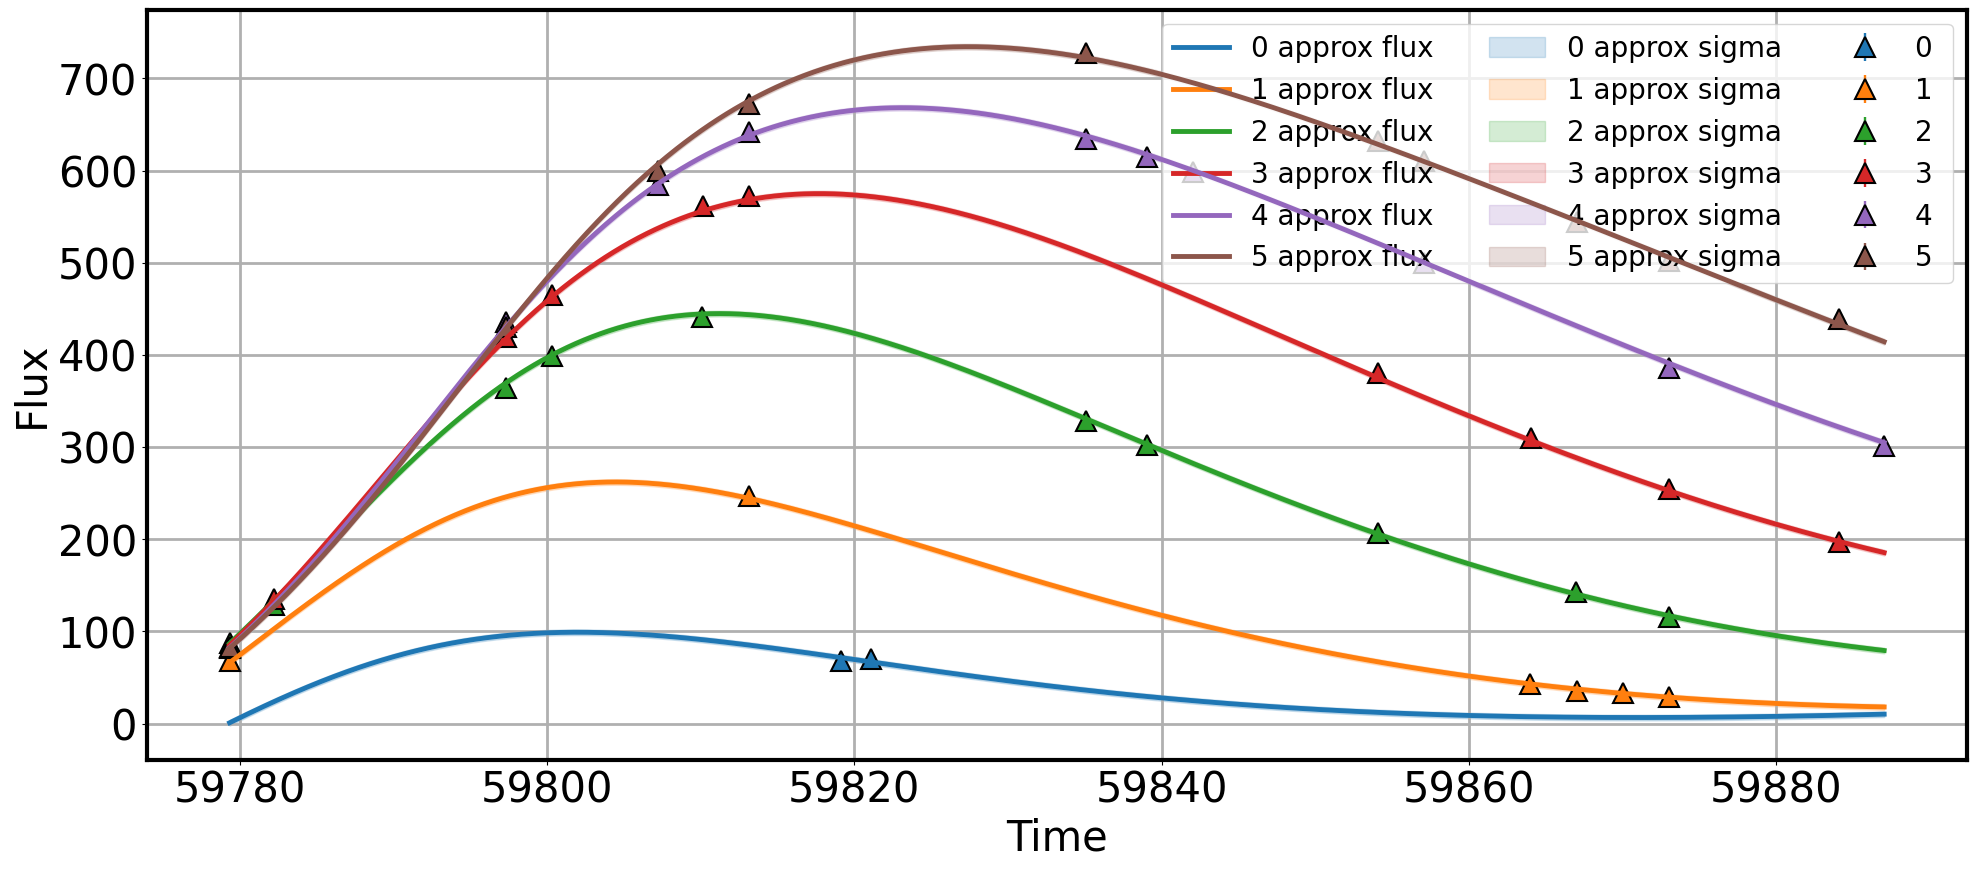

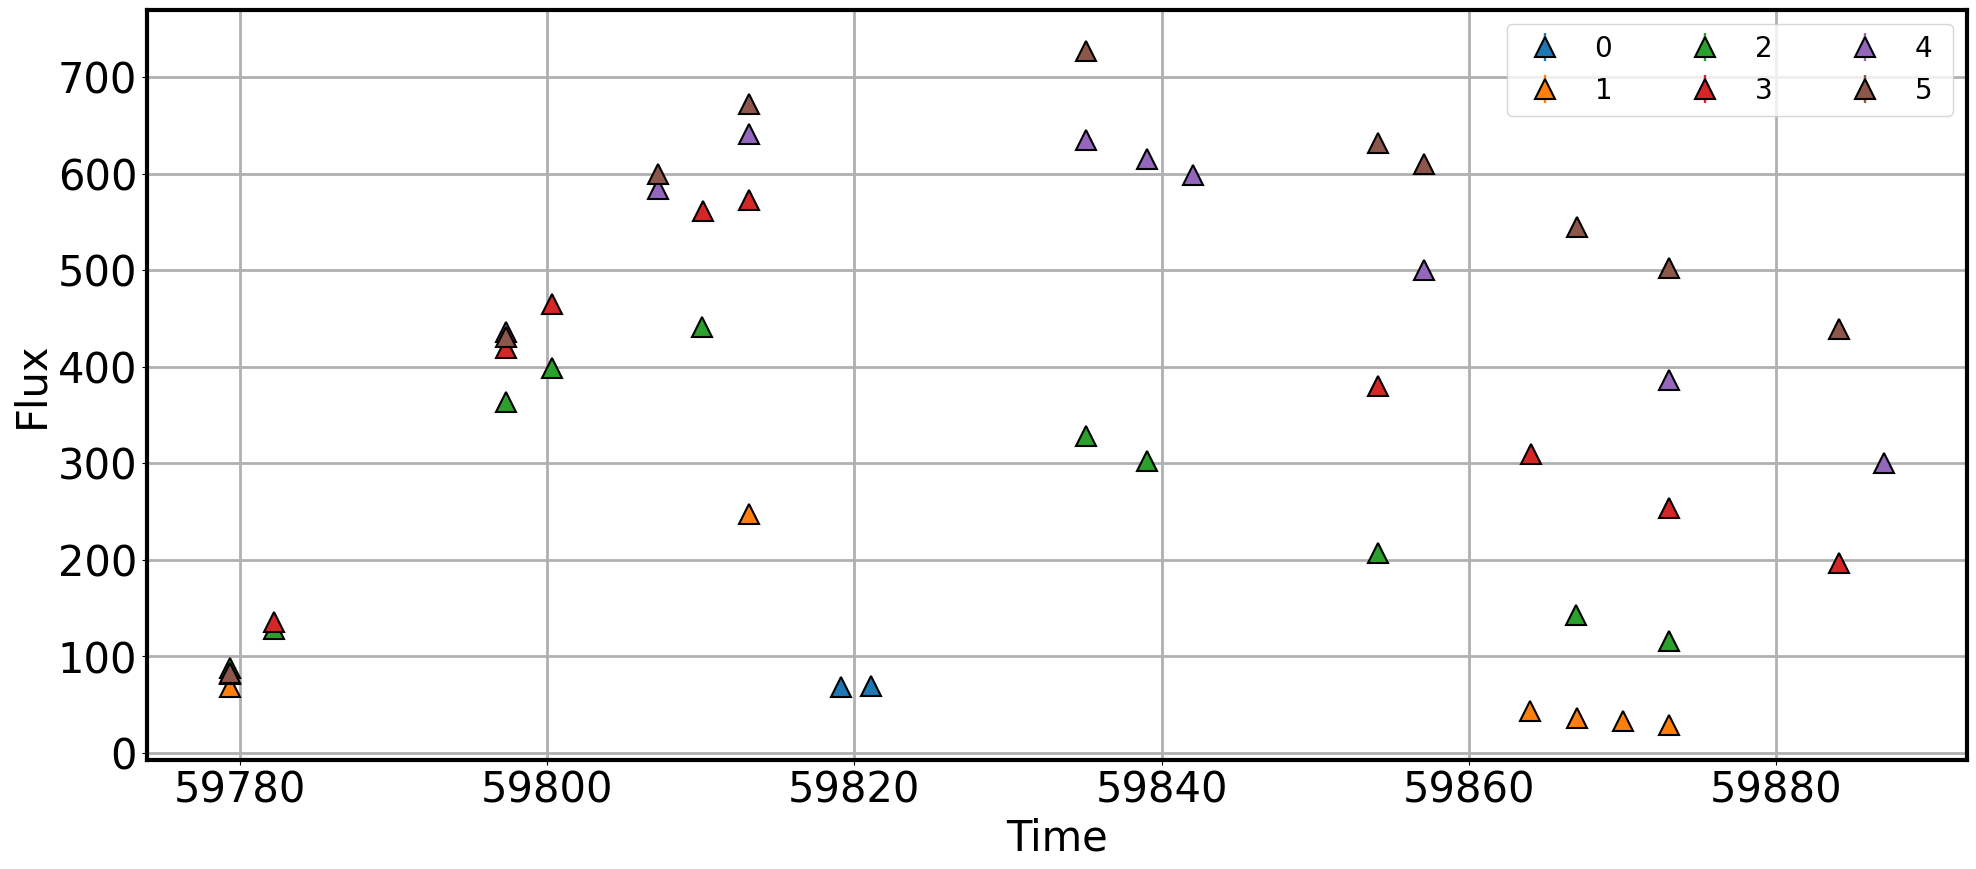

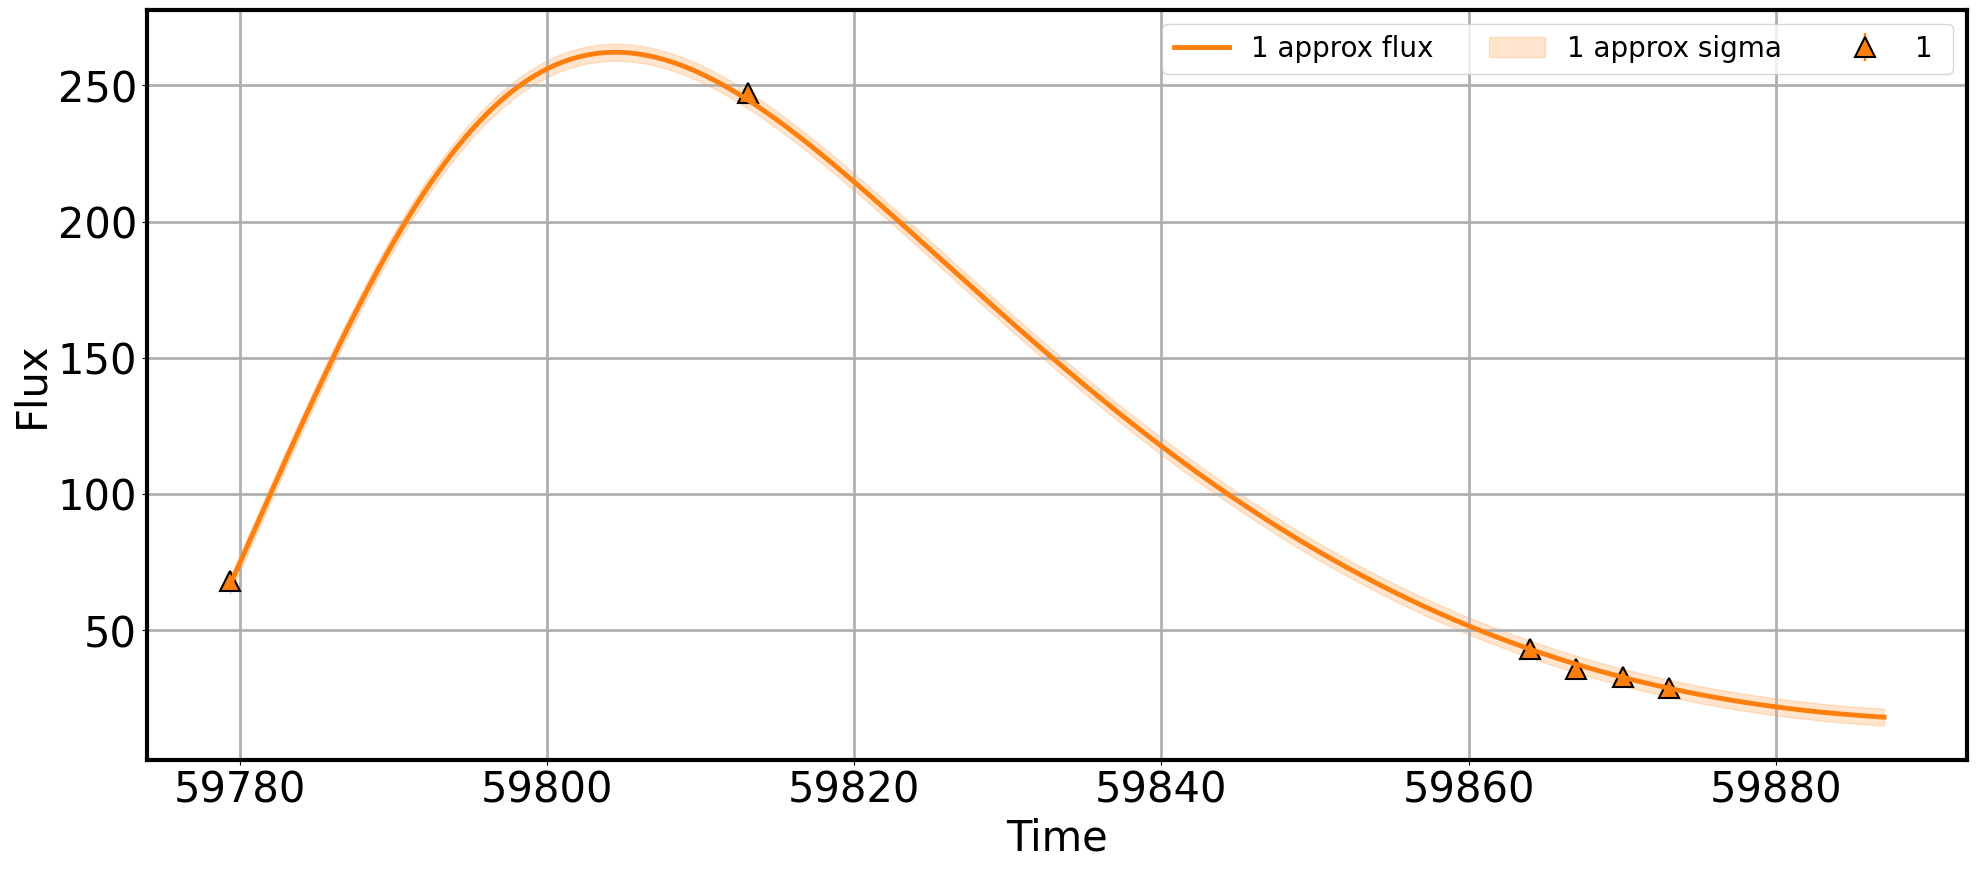

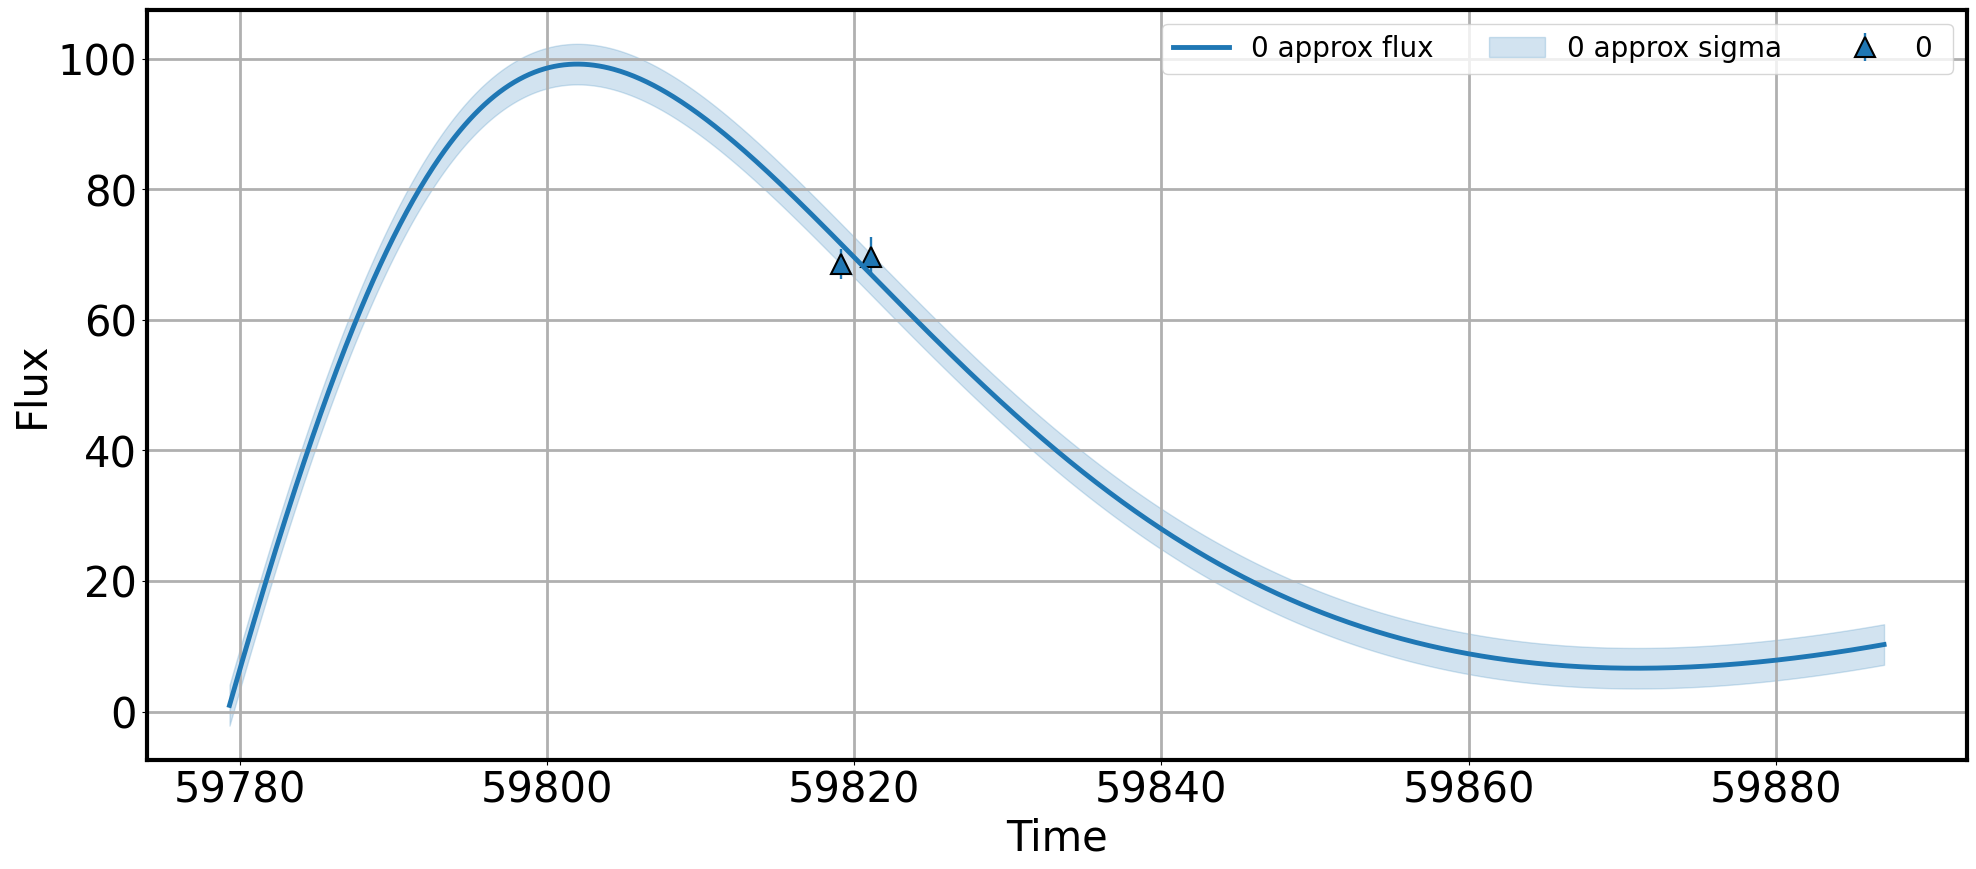

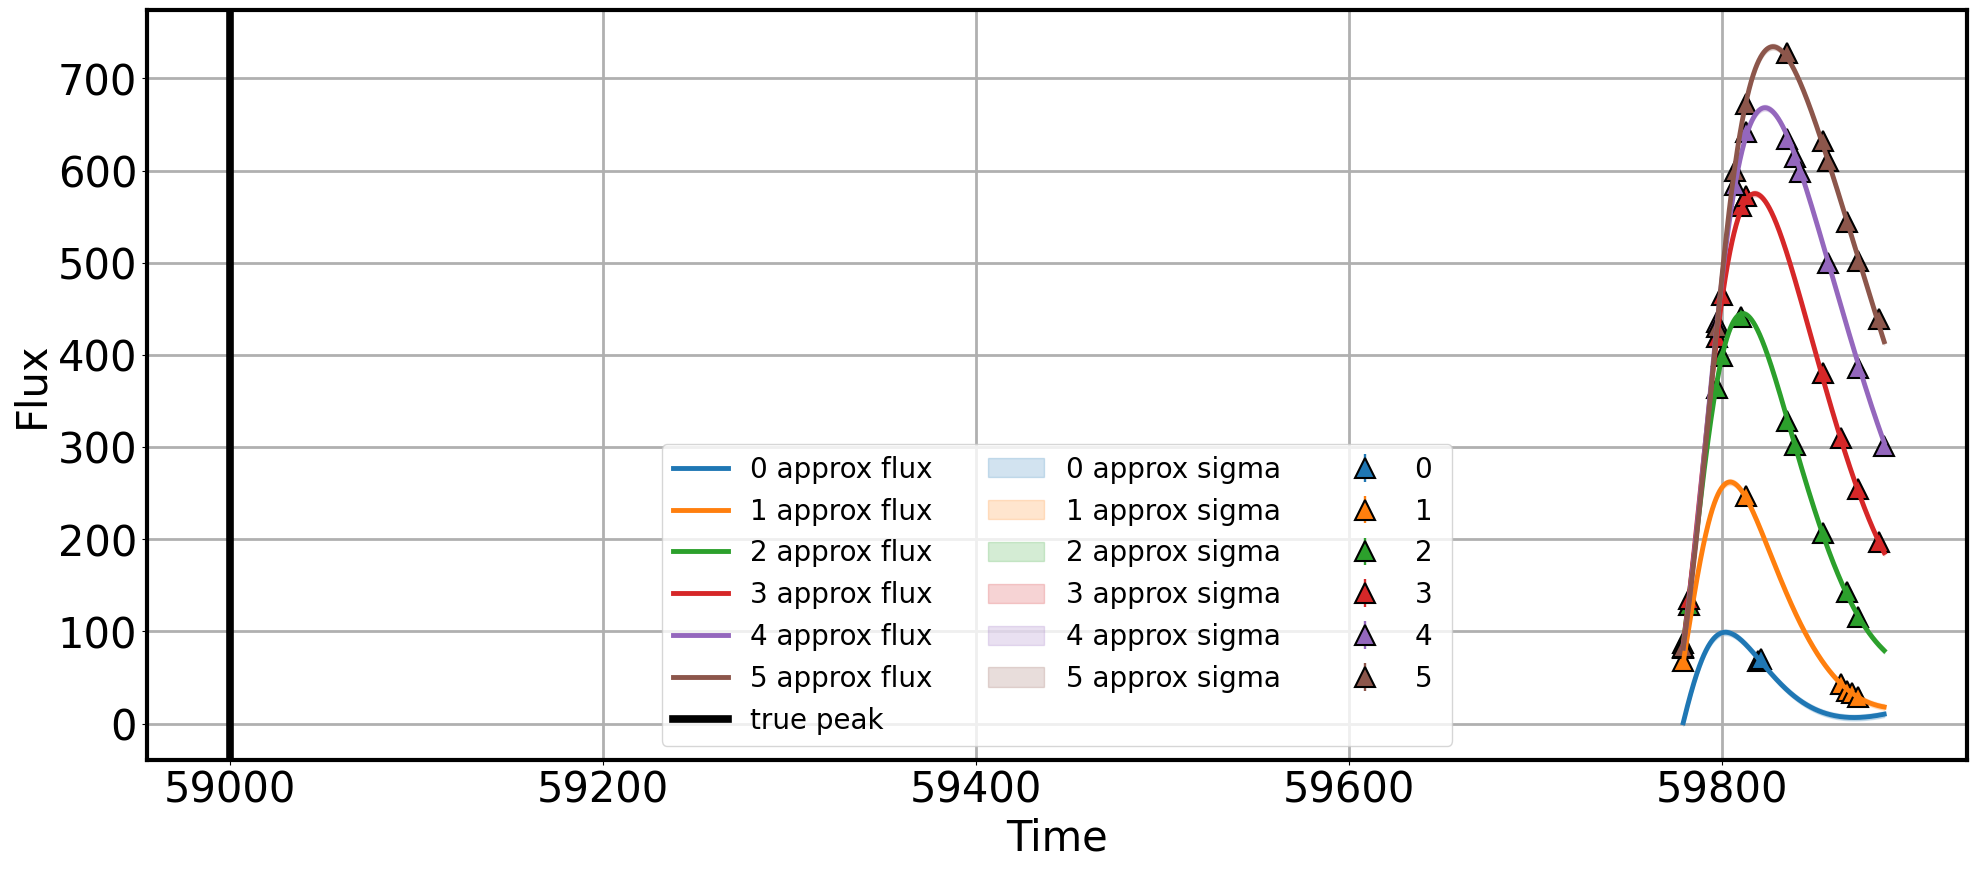

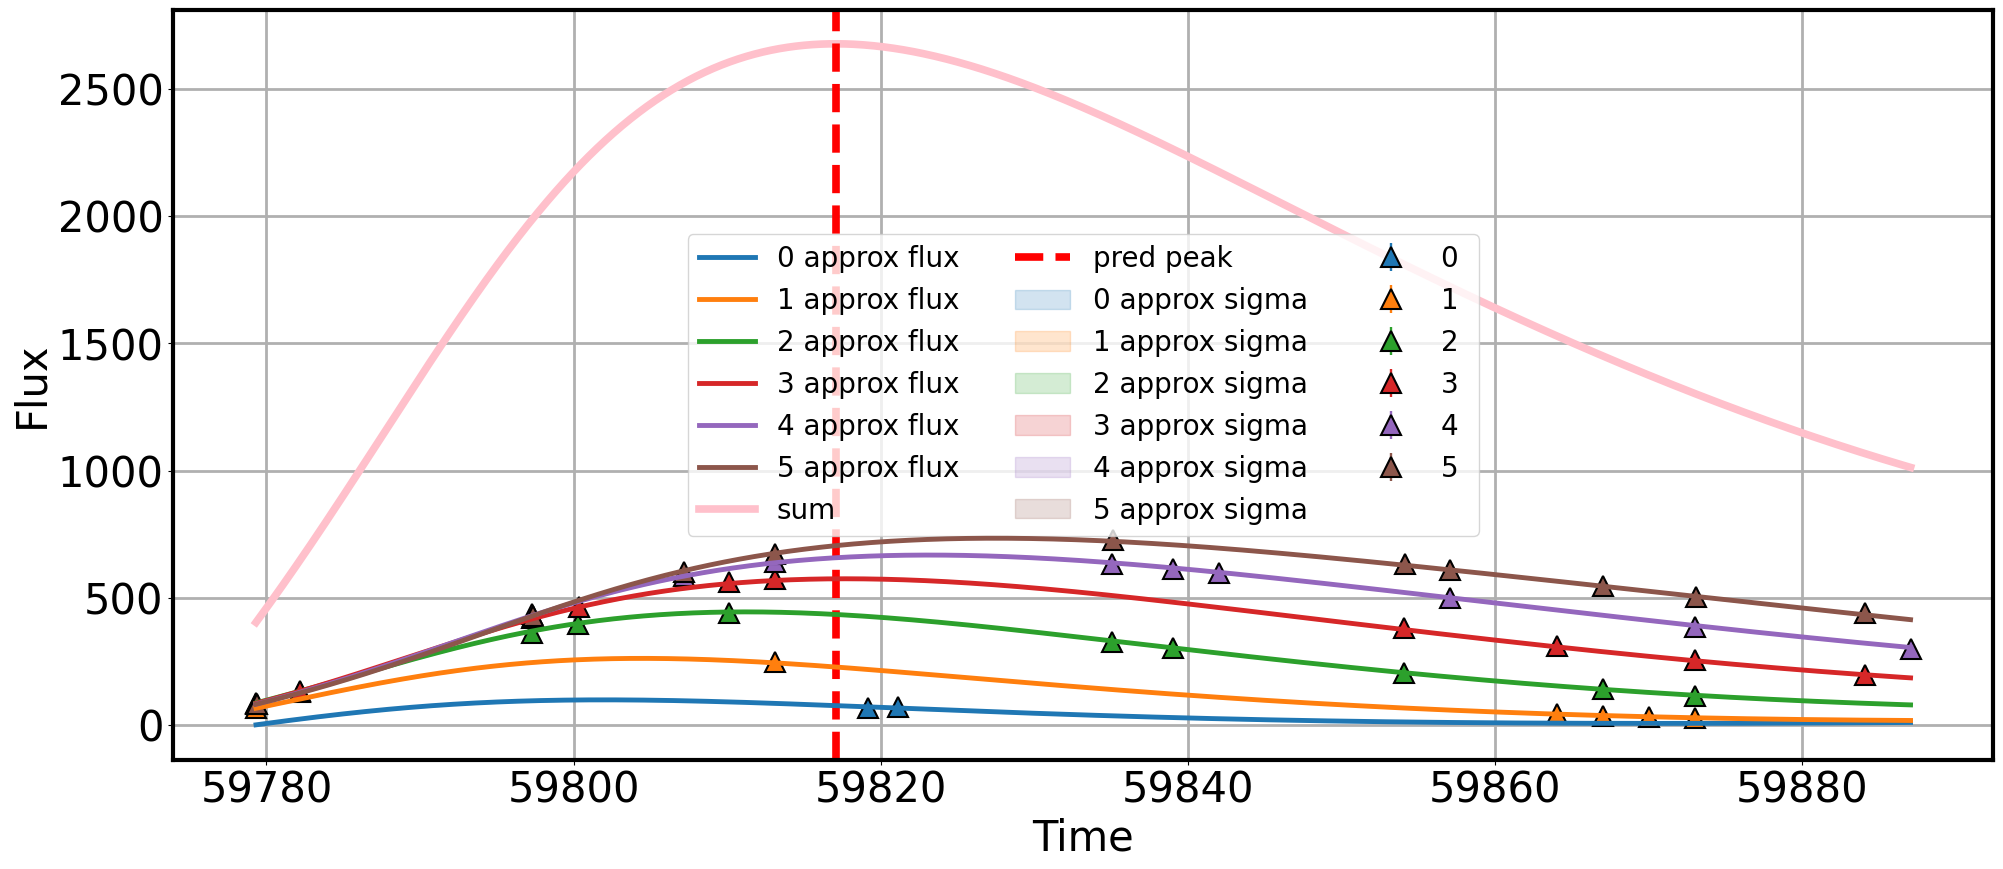

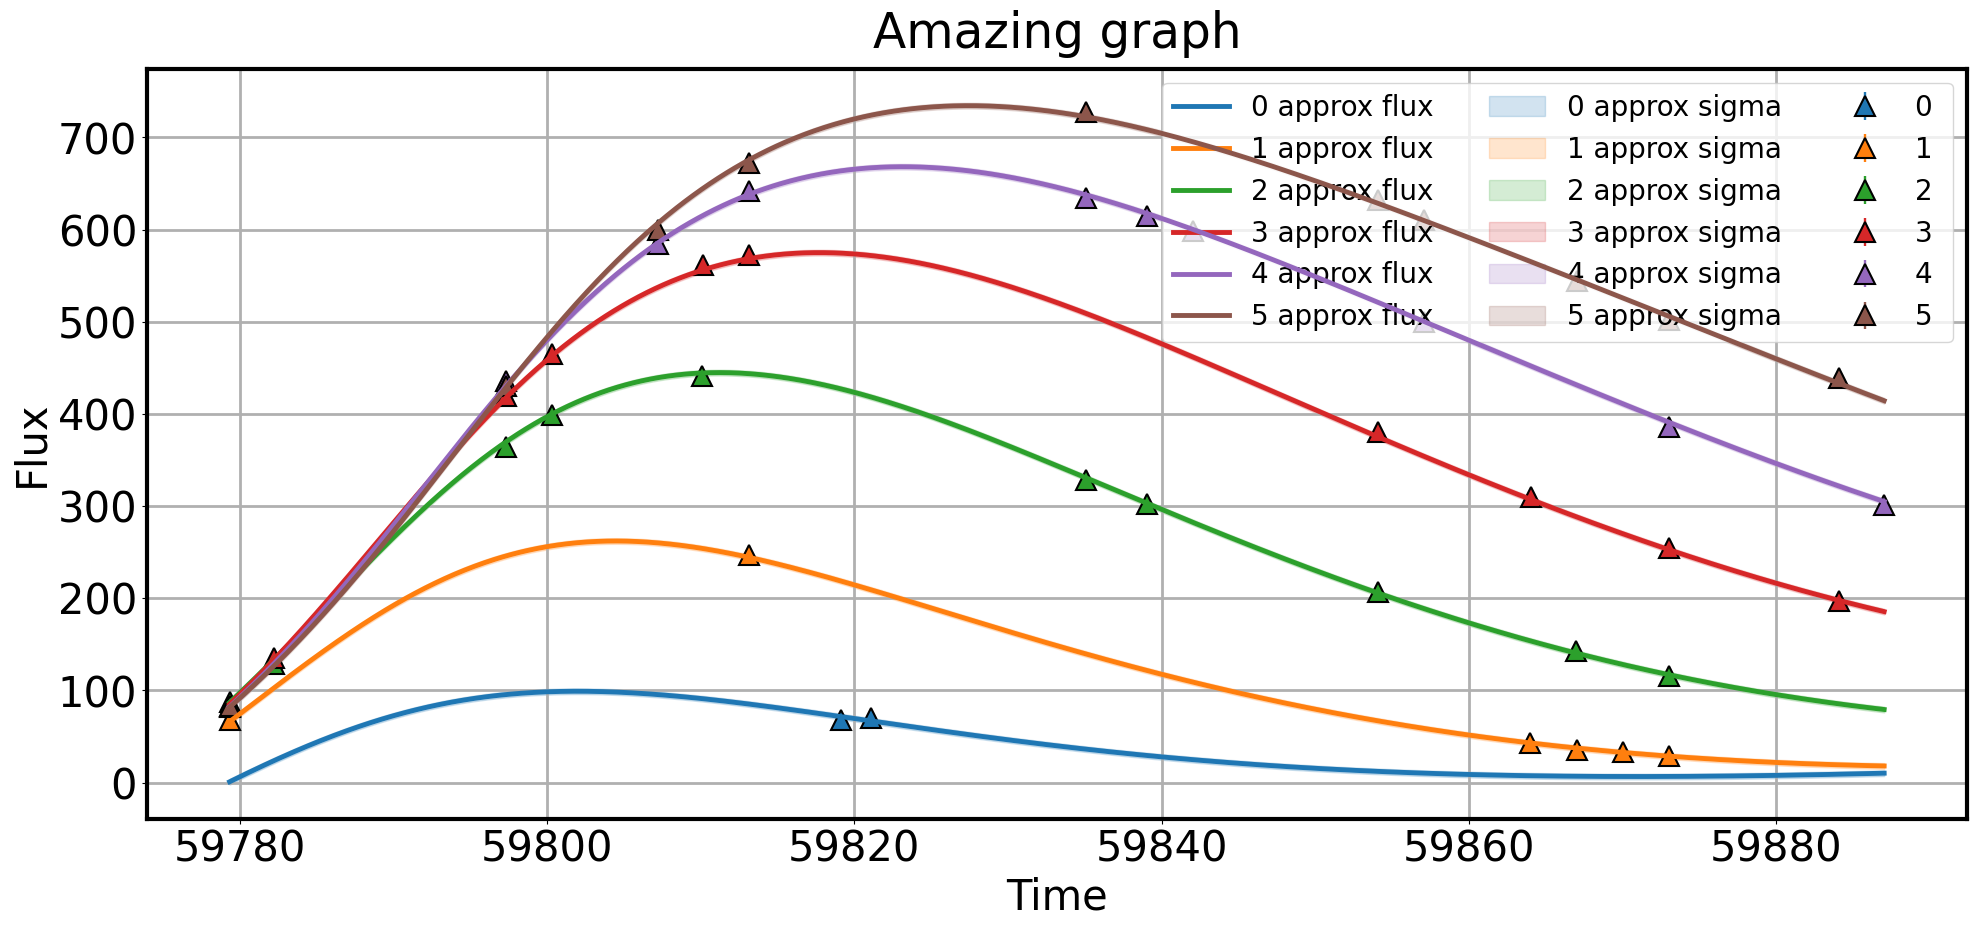

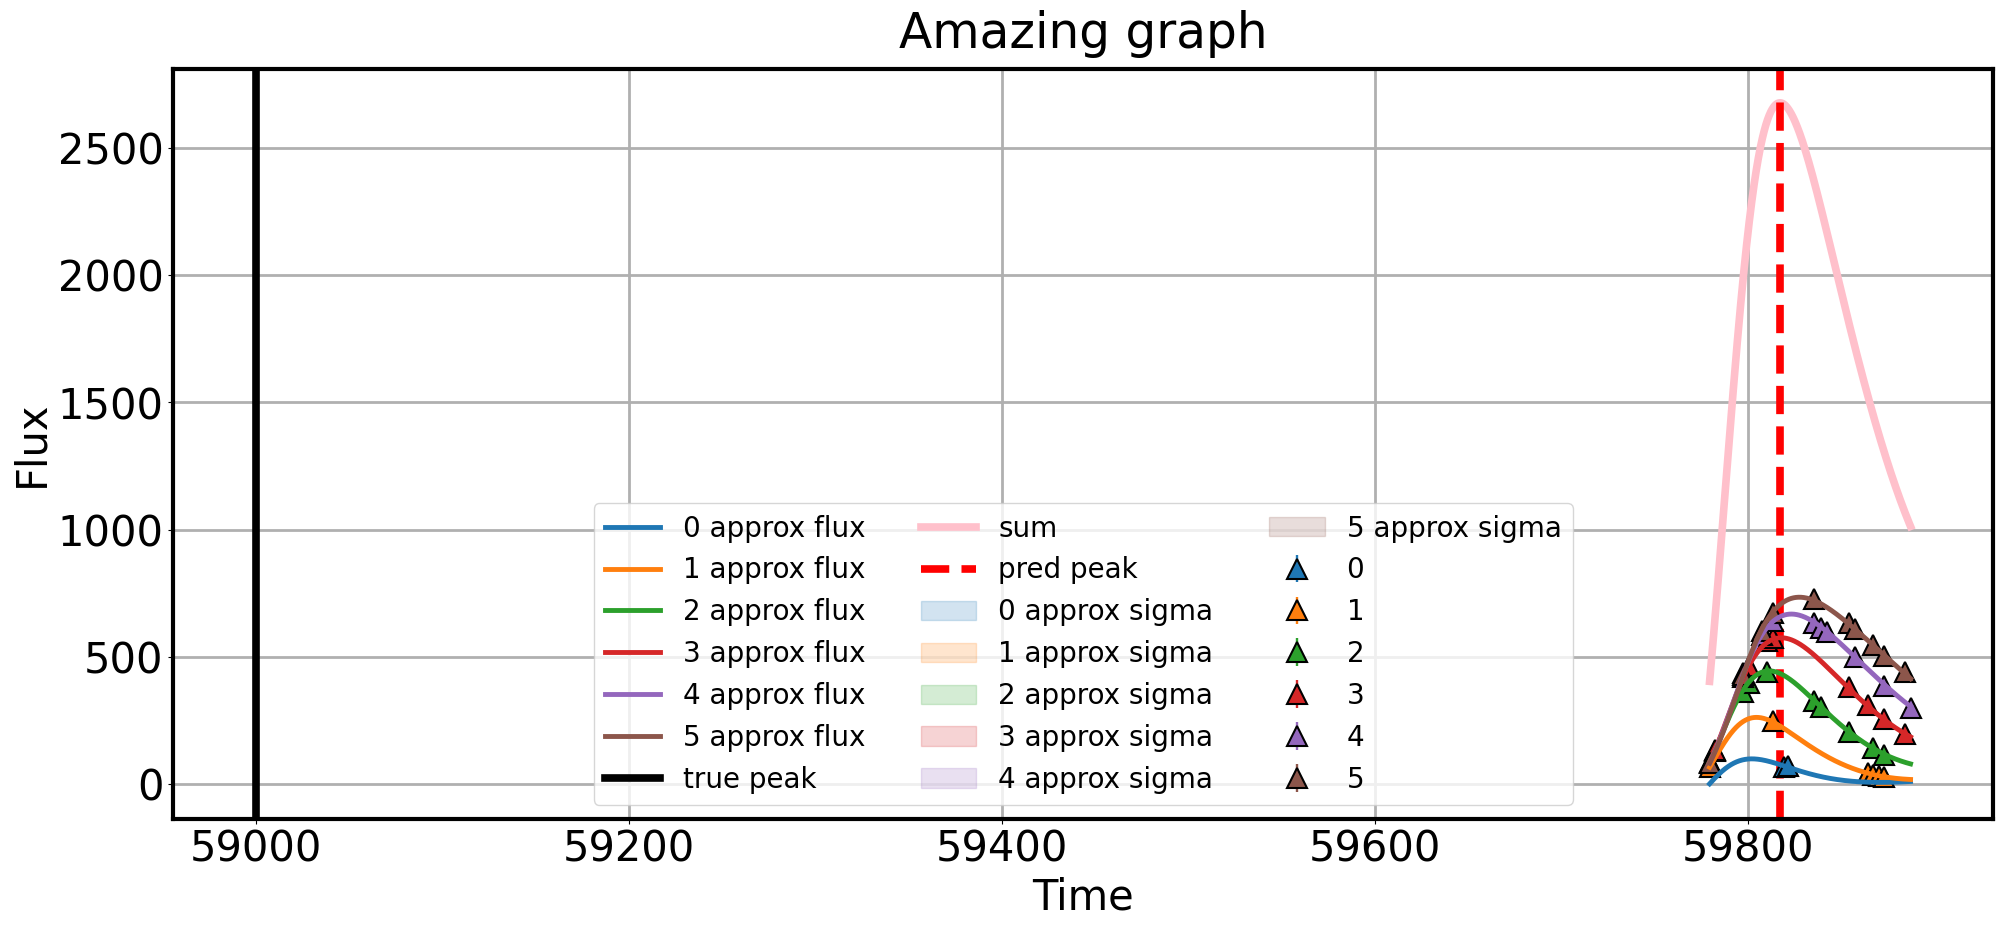

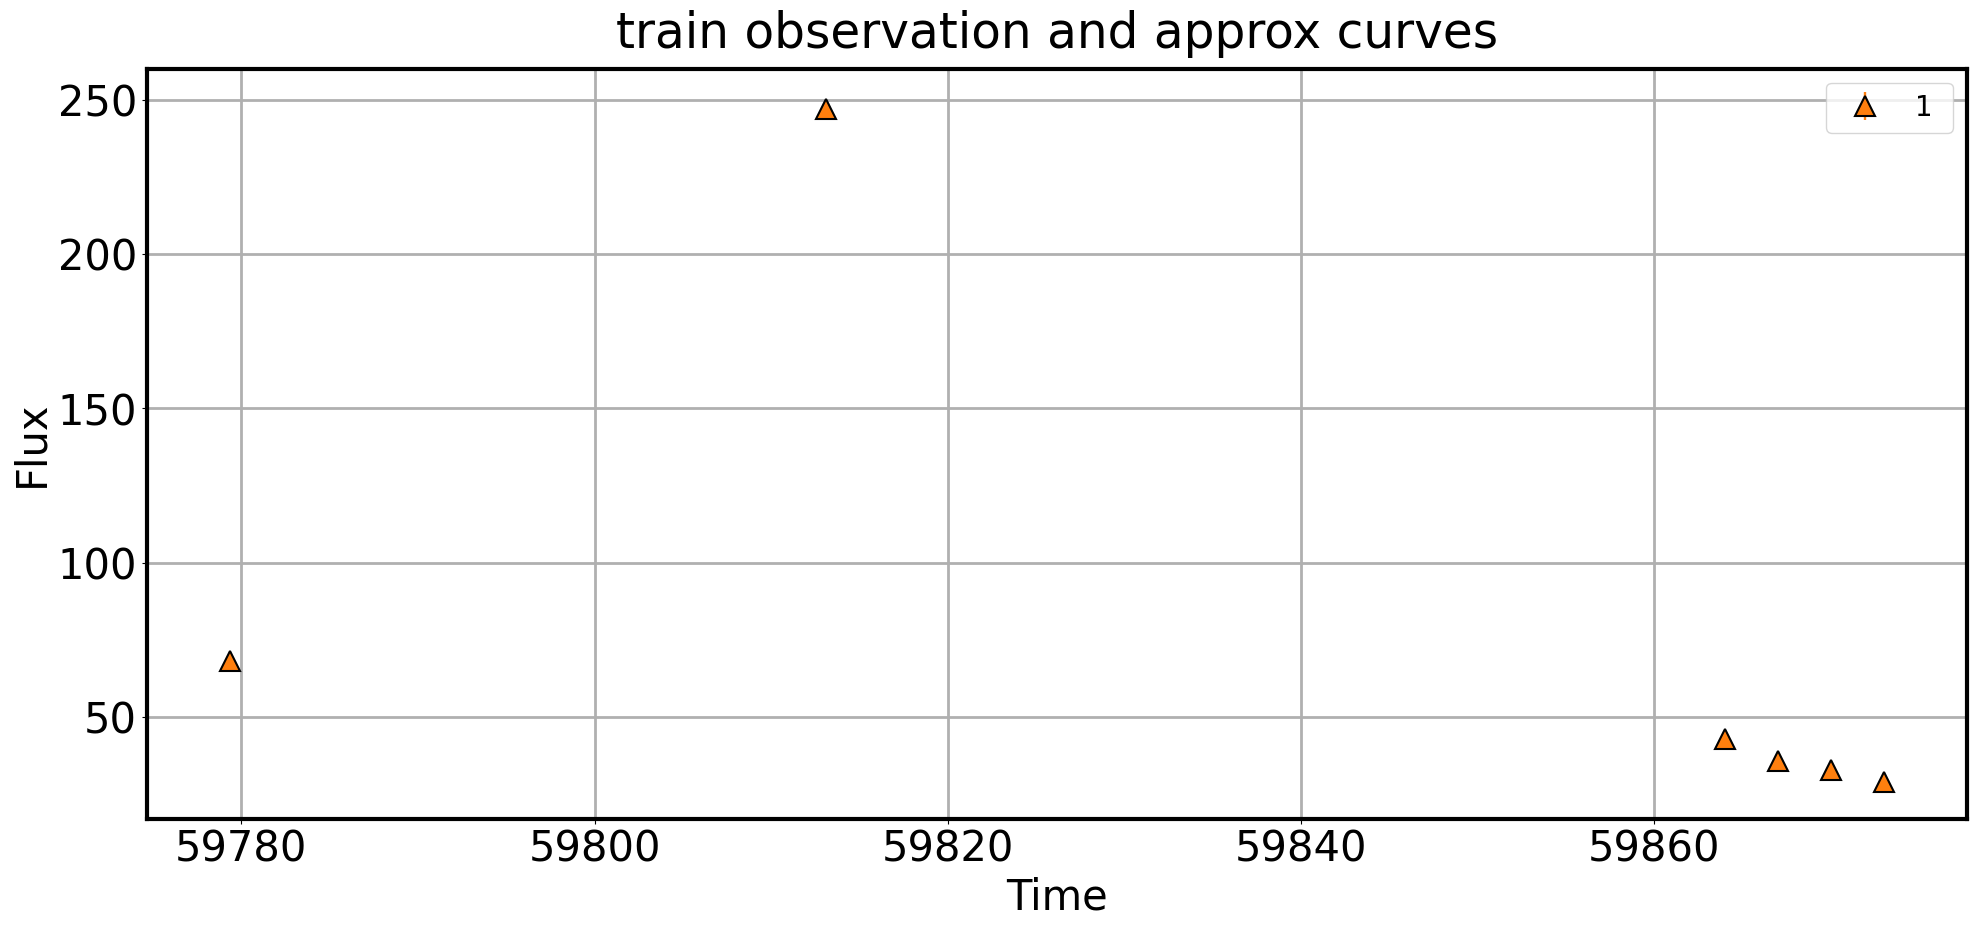

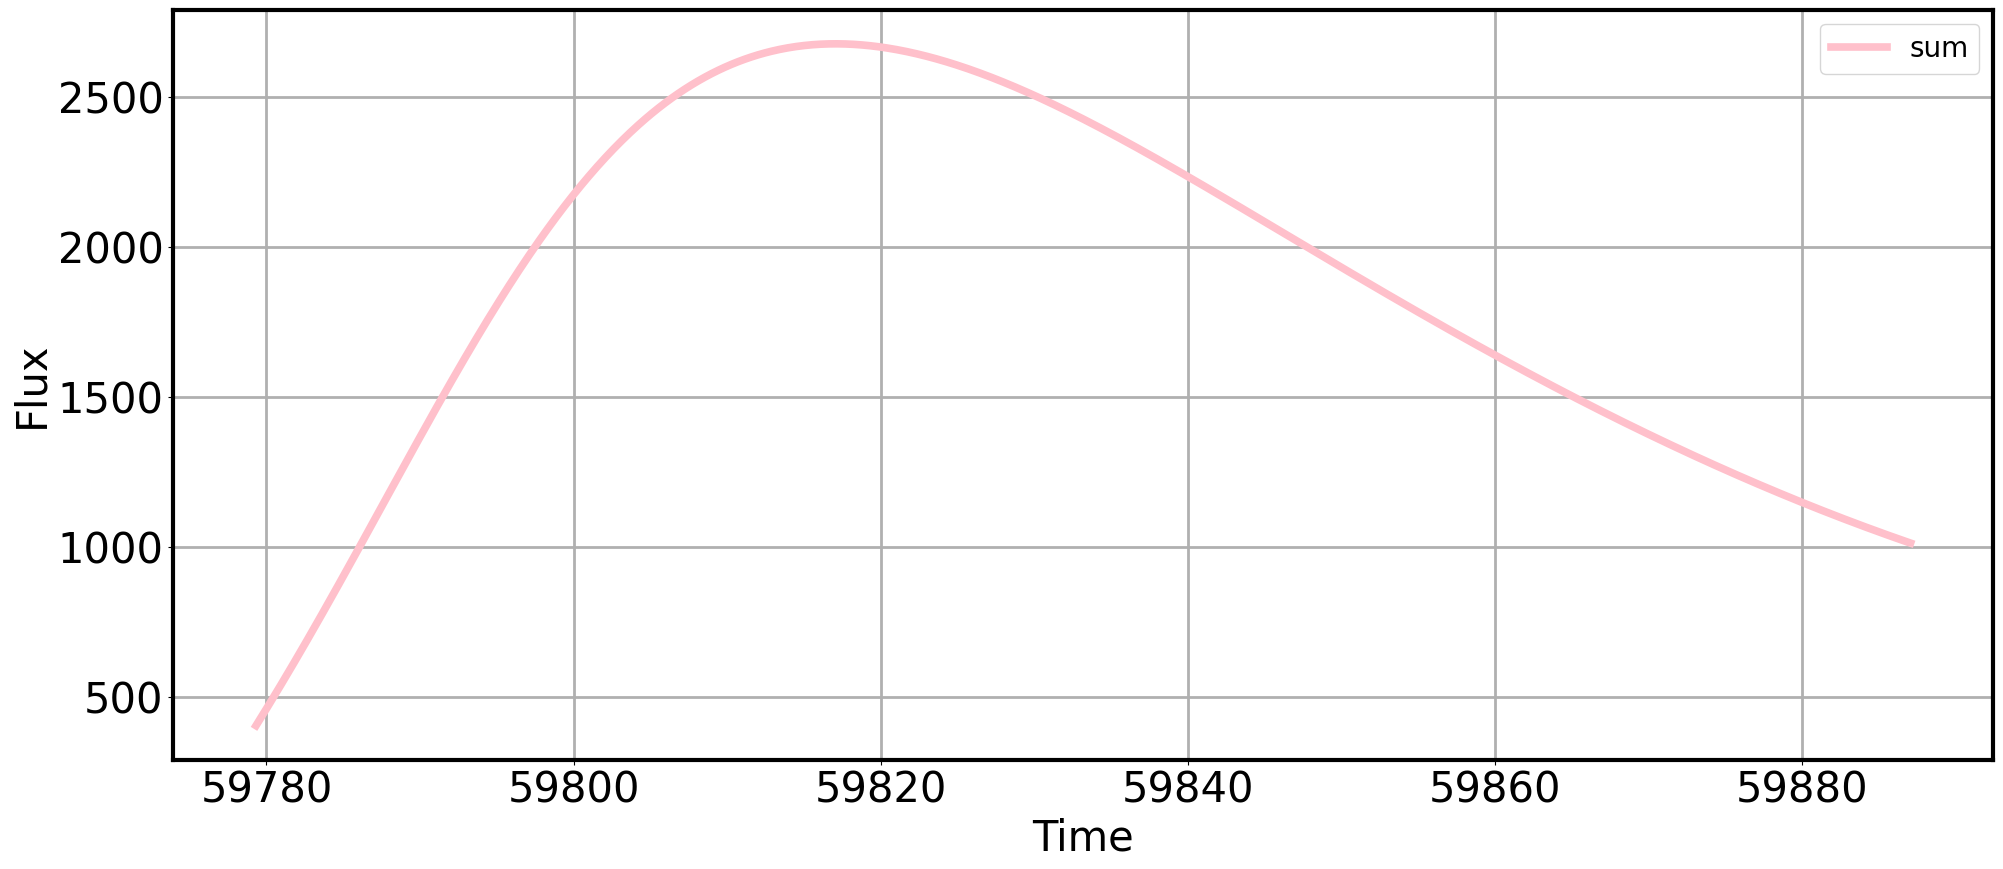

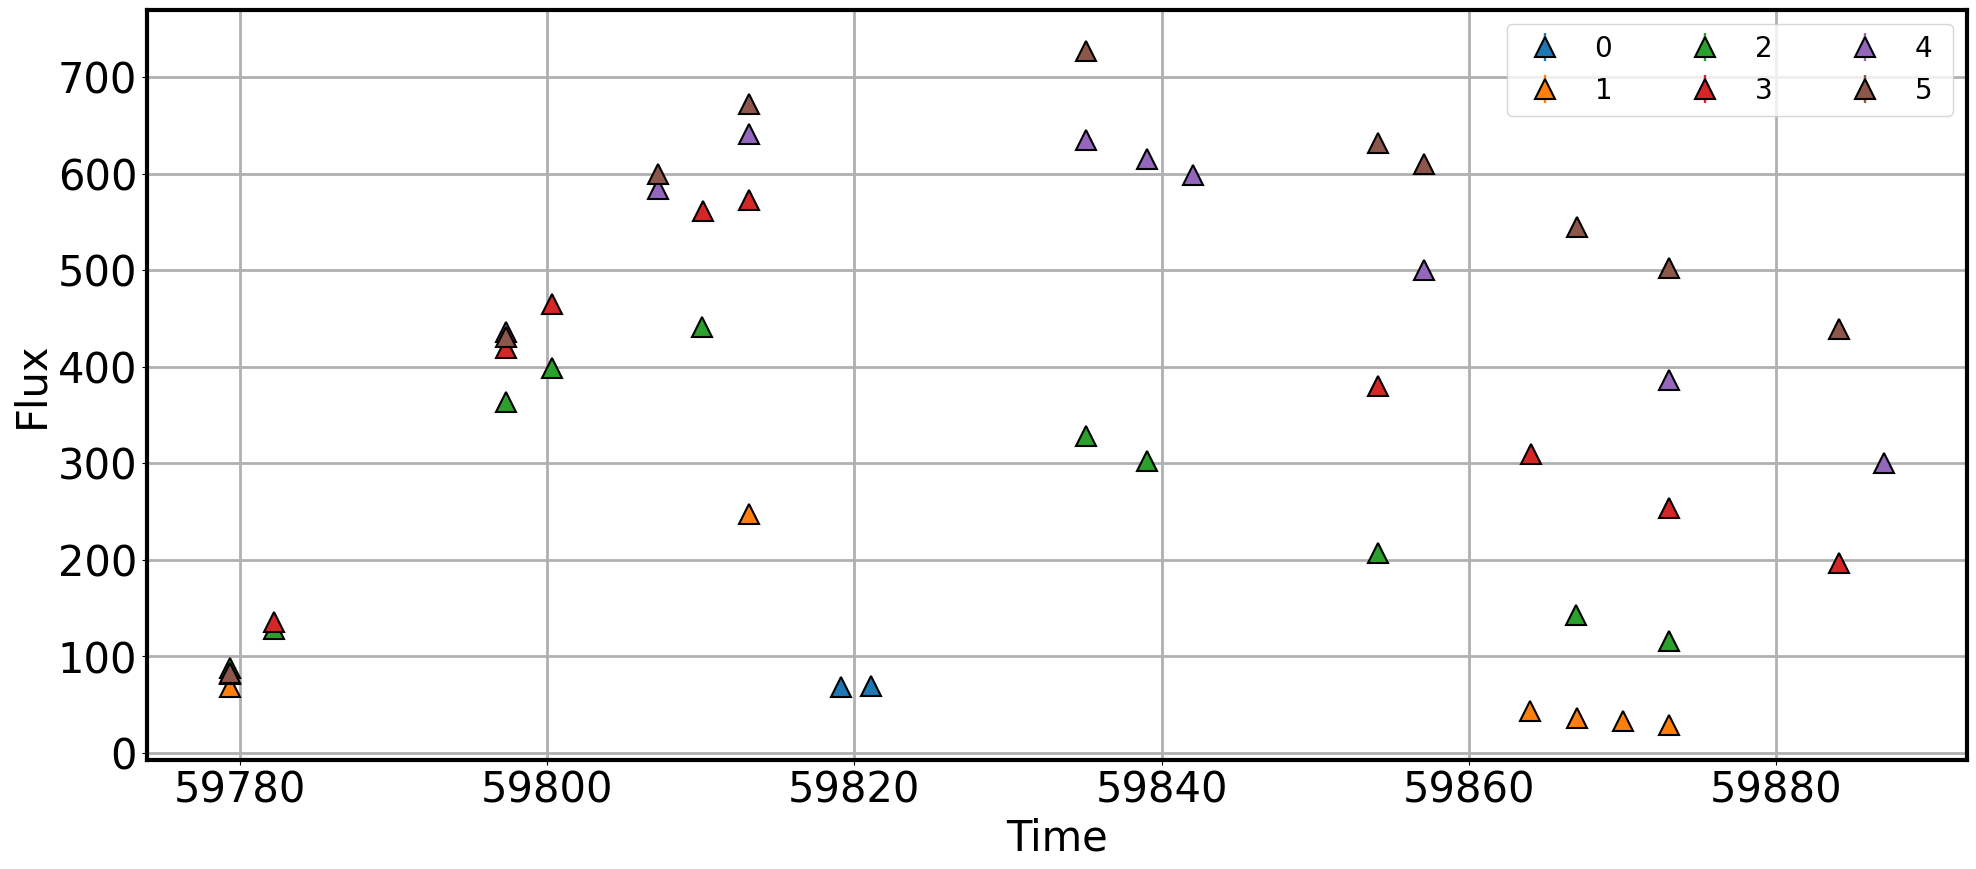

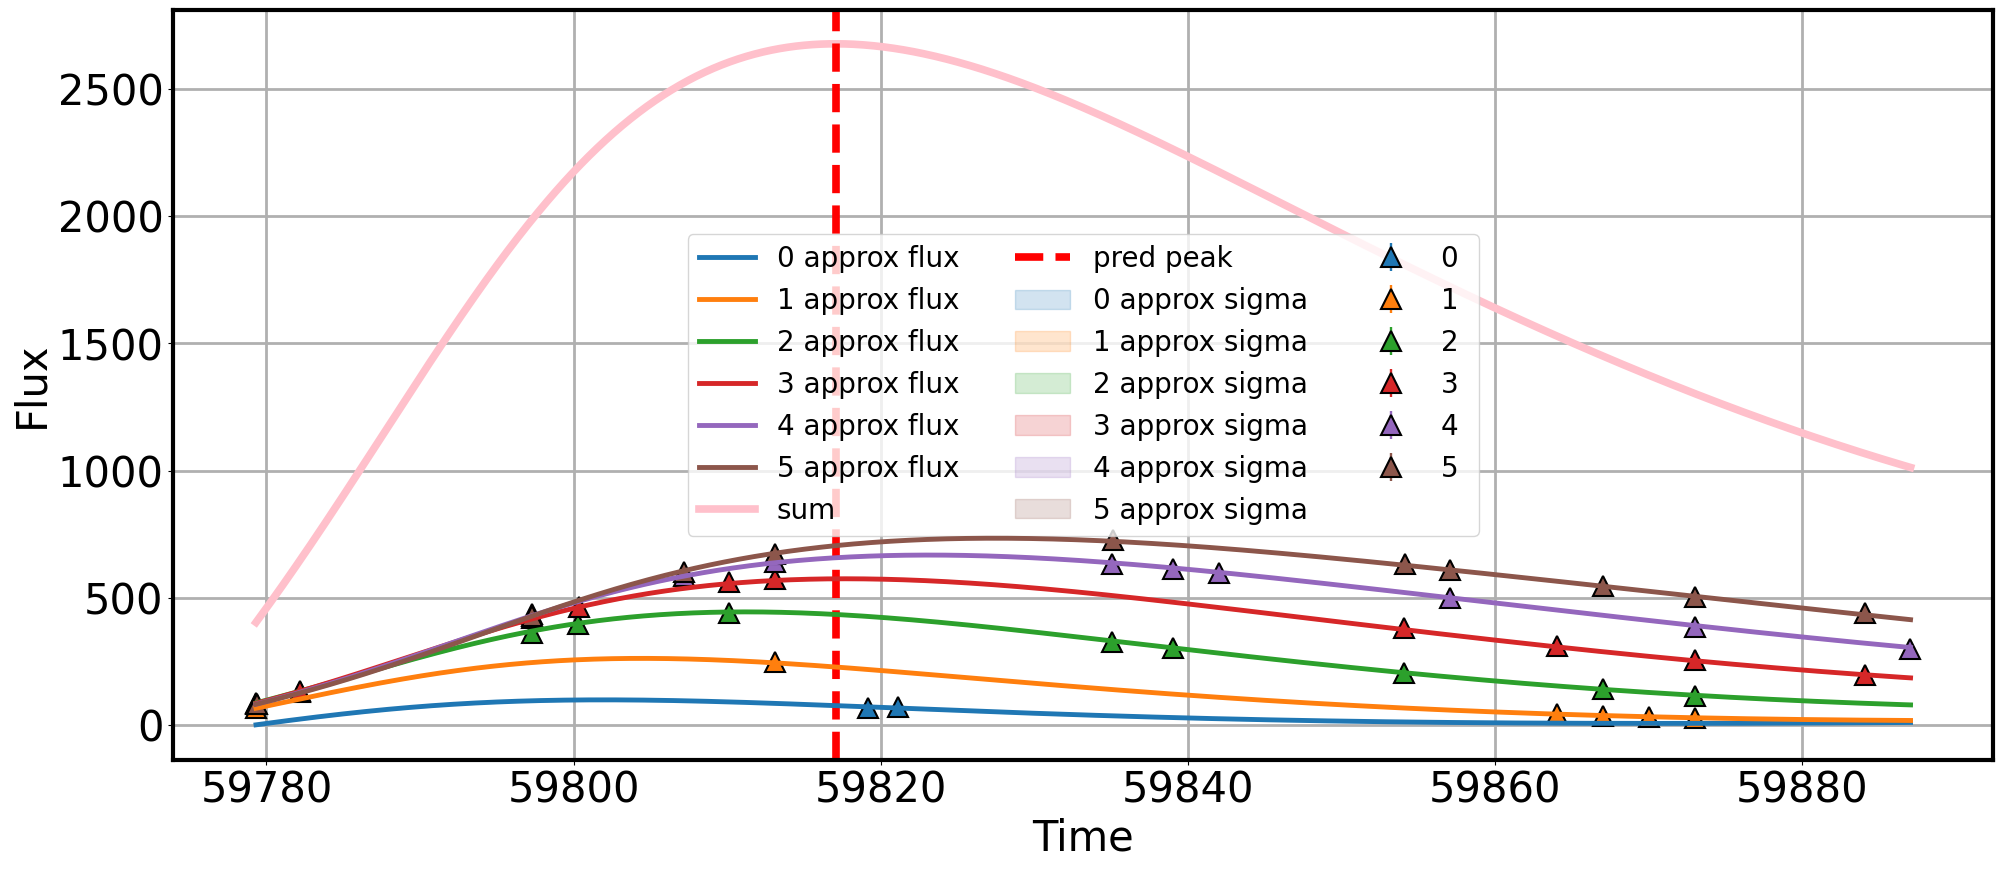

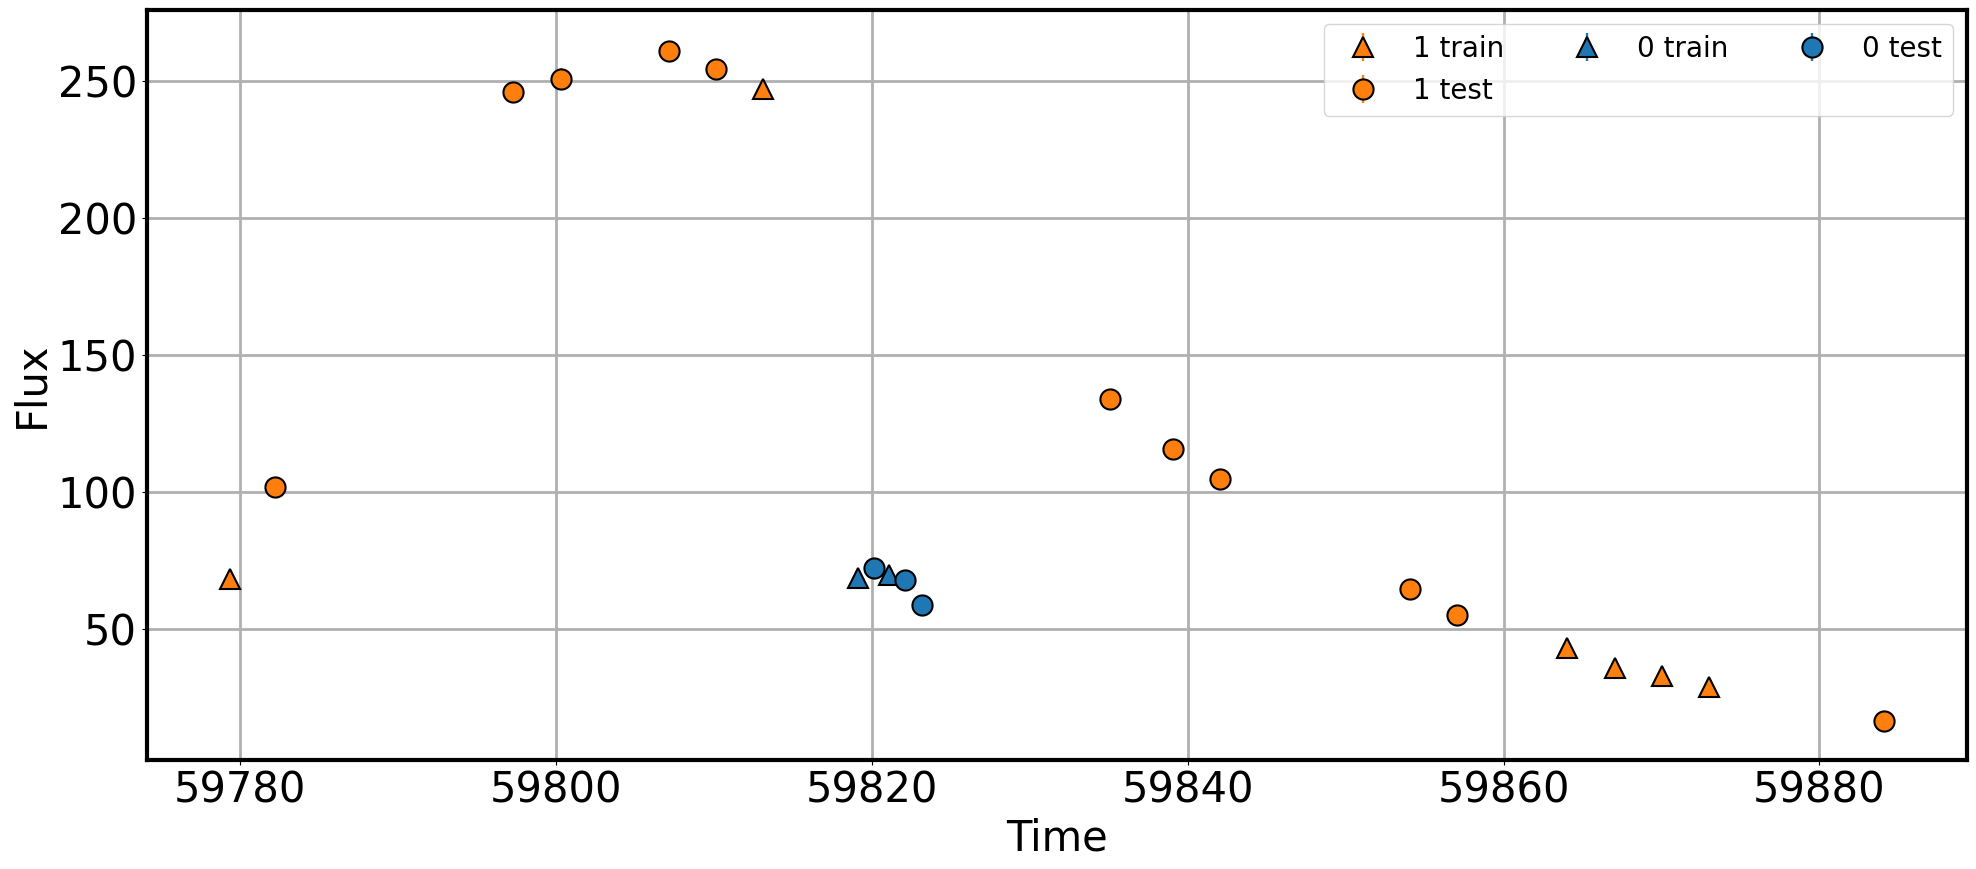

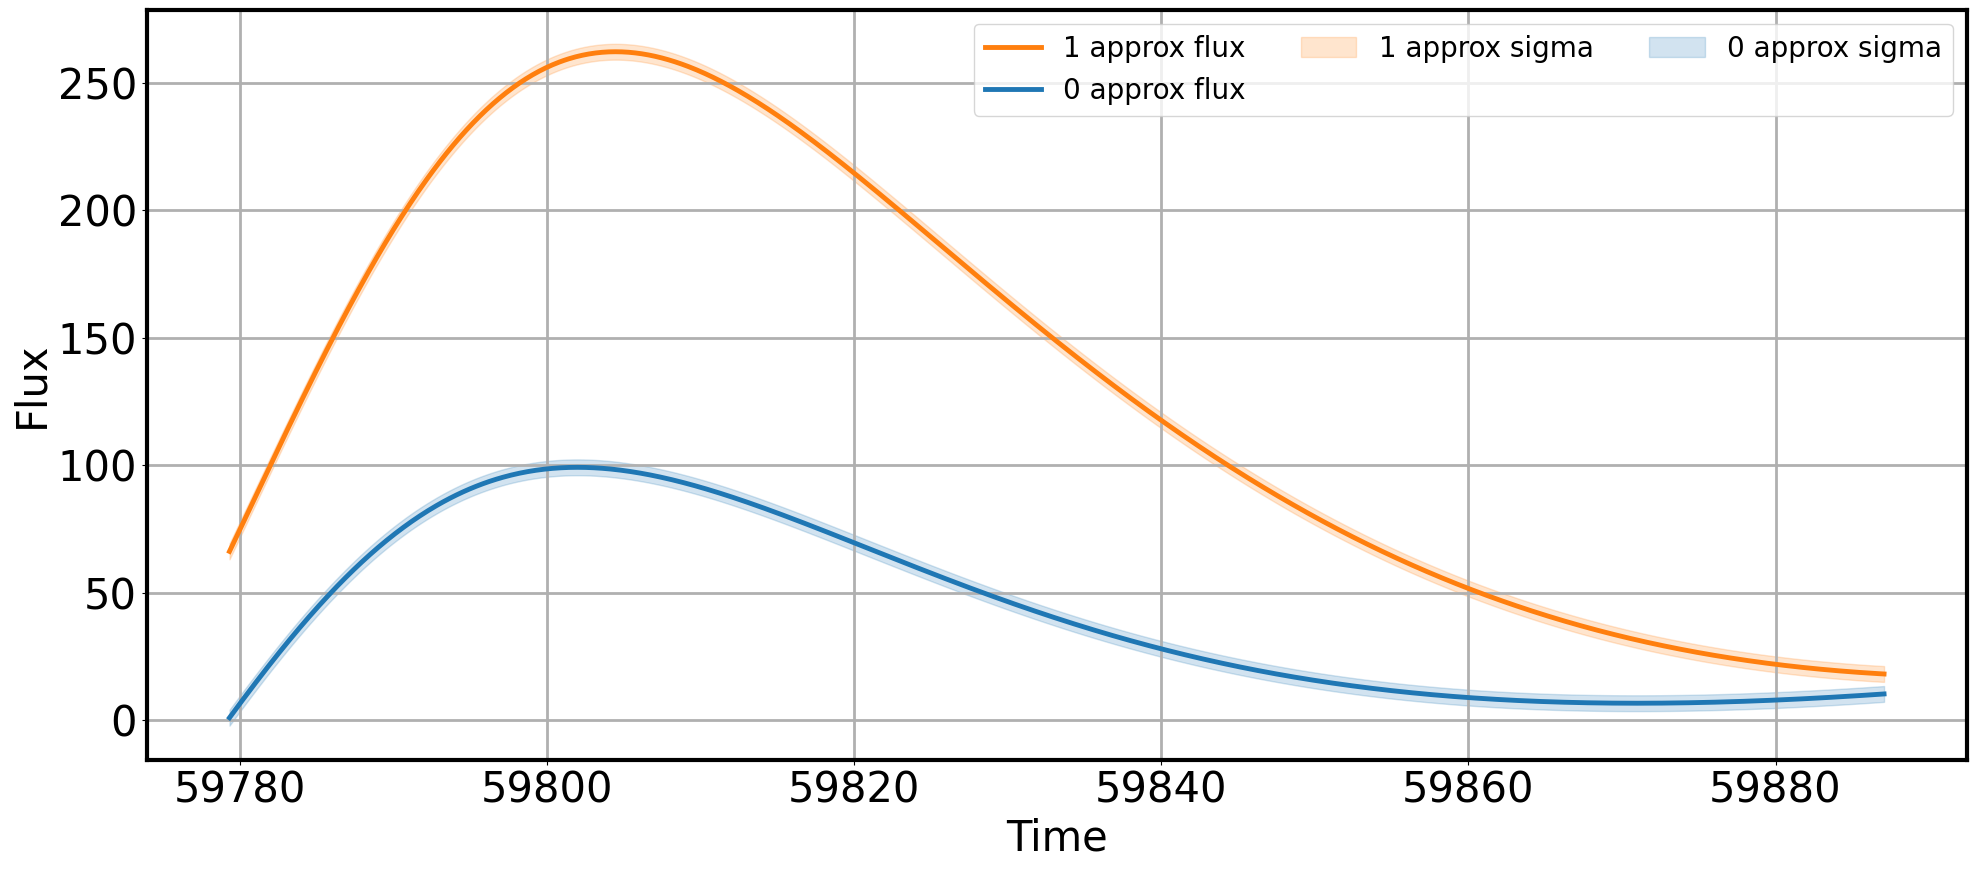

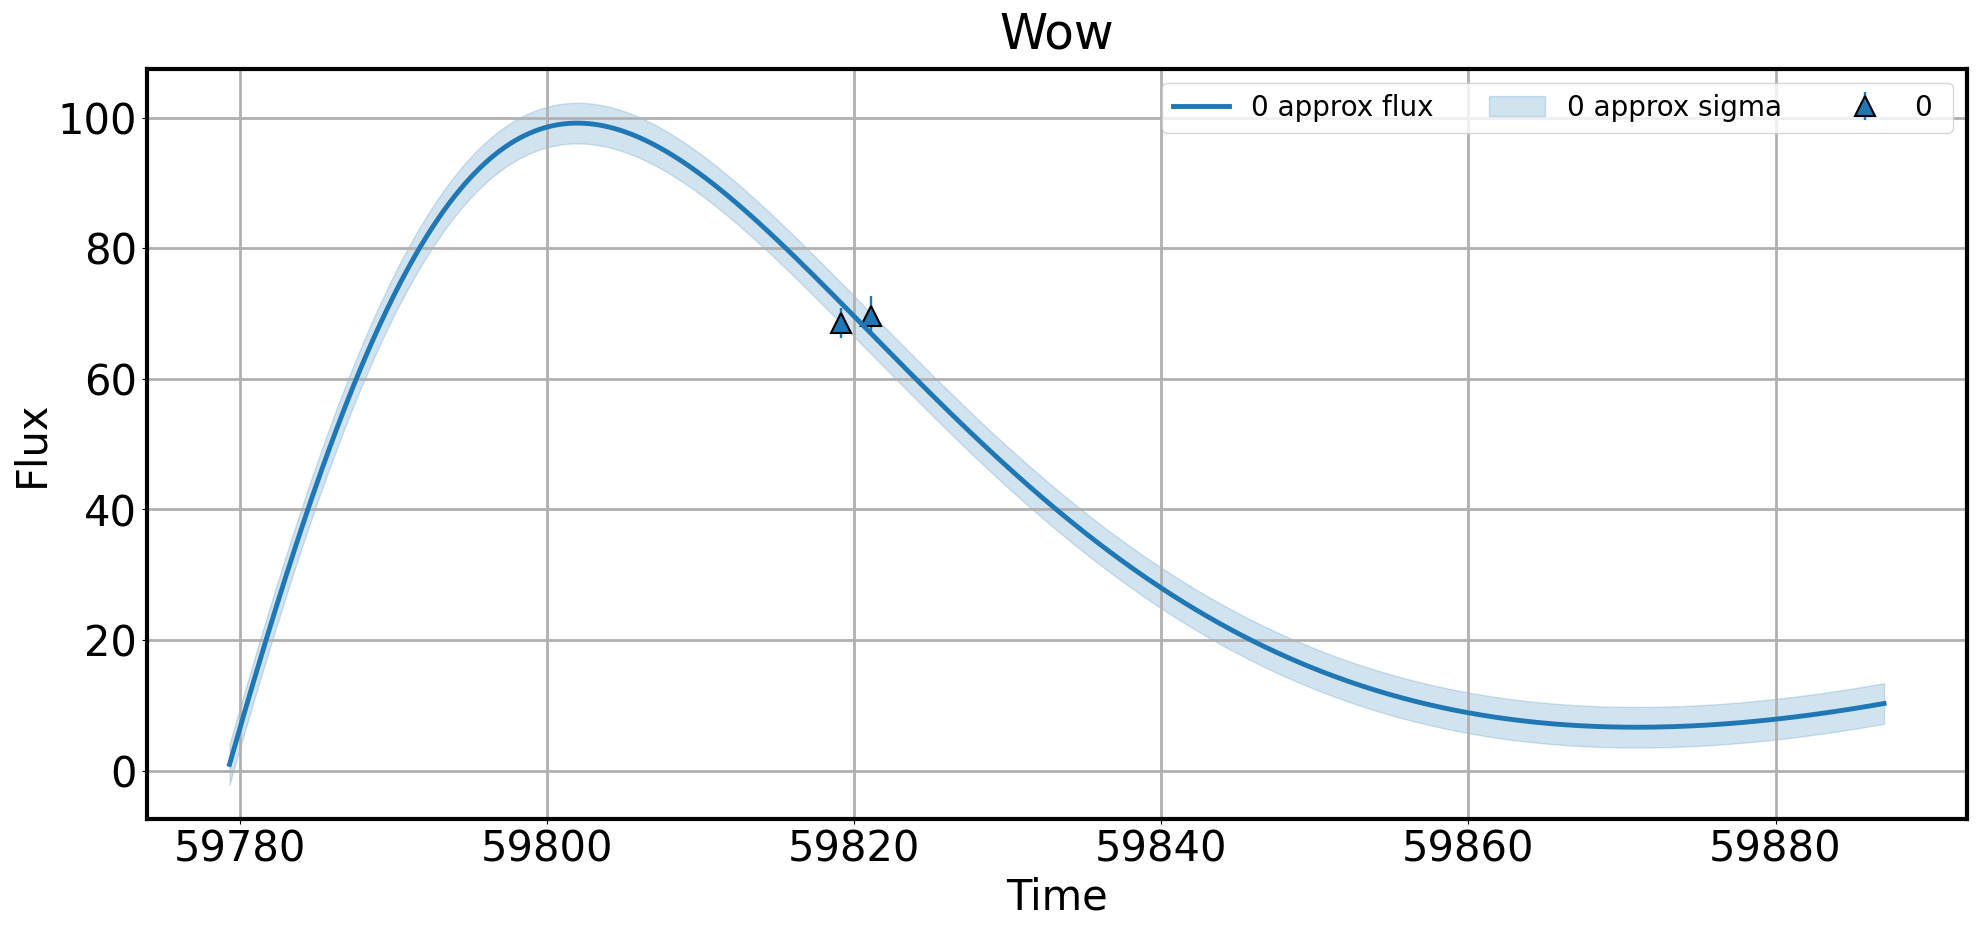

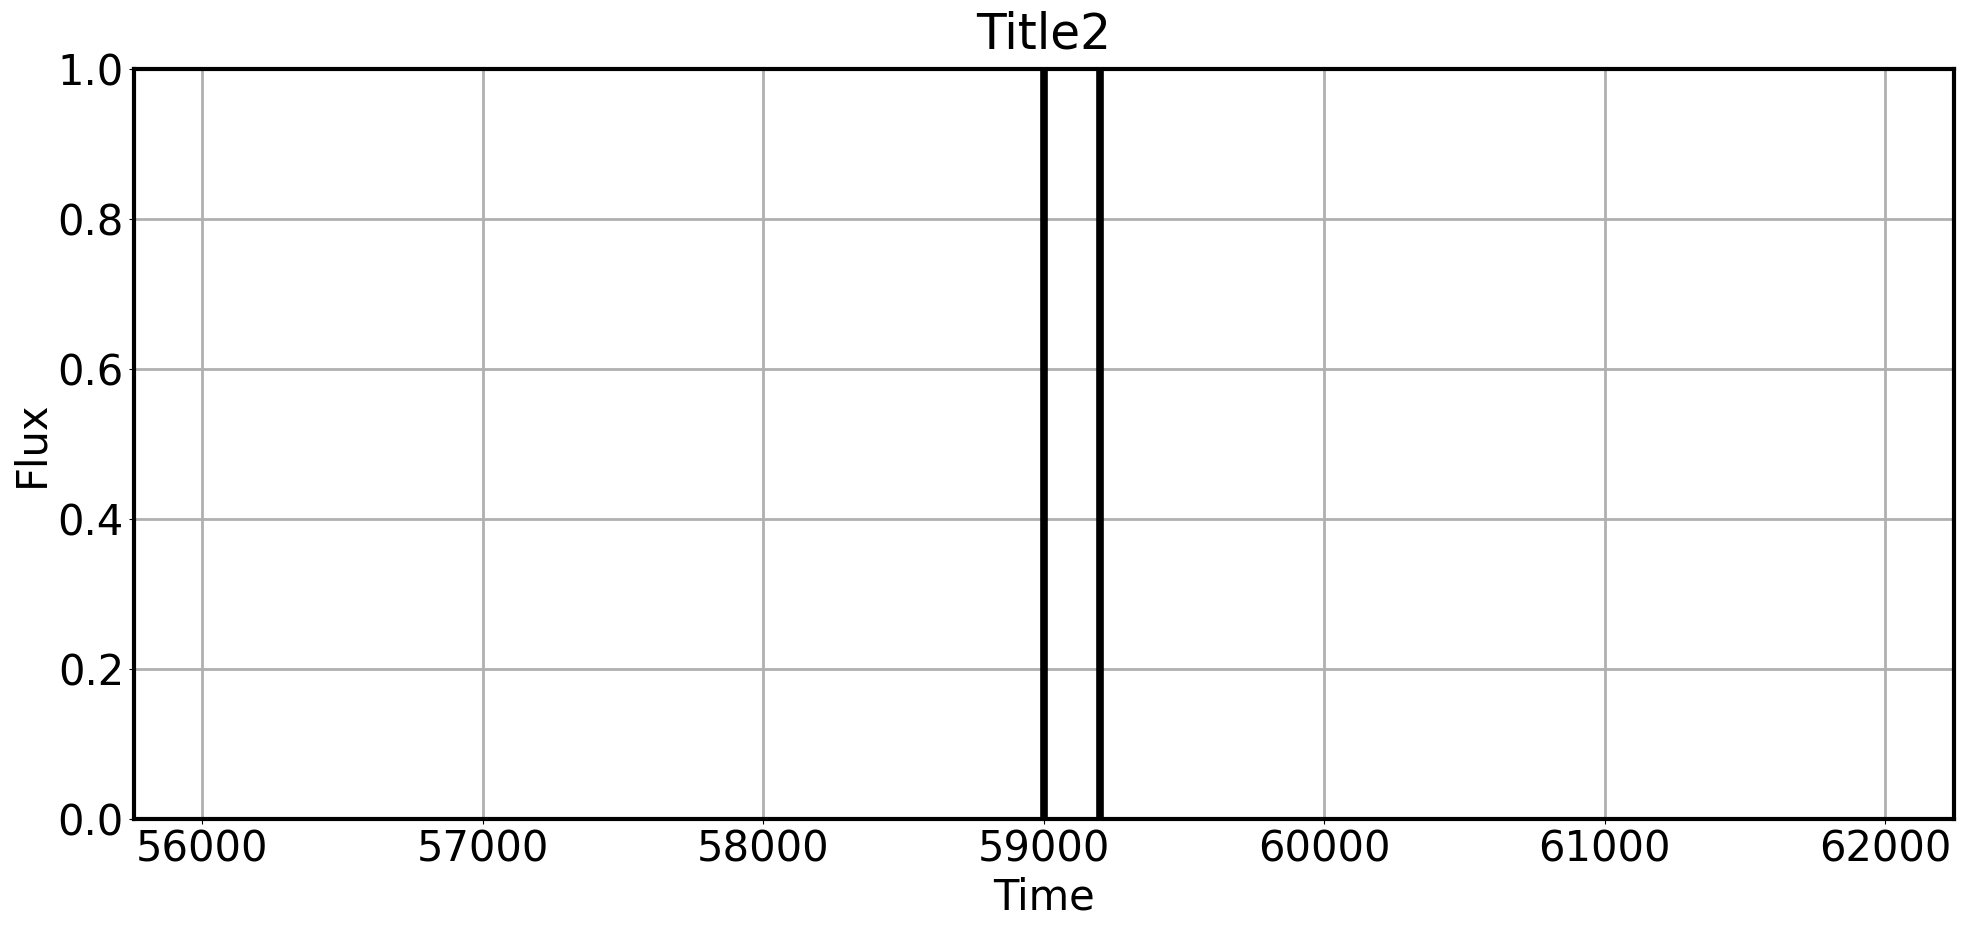

In [19]:
test('NN (sklearn)')